# *Program is to estimate the Bill Authentication Classification*

Variance, Skewness, Curtosis, Entropy are the features 

and 

Class is the Target or Label 

Steps required for installation spark in google colab

In [0]:
!apt-get install openjdk-8-jdk-headless -qq > /dev/null
!wget -q http://www-eu.apache.org/dist/spark/spark-2.4.4/spark-2.4.4-bin-hadoop2.7.tgz
!tar xf spark-2.4.4-bin-hadoop2.7.tgz
!pip install -q findspark

In [0]:
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["SPARK_HOME"] = "/content/spark-2.4.4-bin-hadoop2.7"

In [0]:
import findspark
findspark.init("spark-2.4.4-bin-hadoop2.7")# SPARK_HOME
from pyspark.sql import SparkSession
spark = SparkSession.builder.master("local[*]").getOrCreate()

In [118]:
# Reading the csv file by using spark

df_spark = spark.read.csv('bill_authentication.csv', inferSchema=True, header=True)
print(type(df_spark))

<class 'pyspark.sql.dataframe.DataFrame'>


In [119]:
df_spark.printSchema() # print detail schema of data
df_spark.show()# show top 20 rows
# Do more operation on it.

root
 |-- Variance: double (nullable = true)
 |-- Skewness: double (nullable = true)
 |-- Curtosis: double (nullable = true)
 |-- Entropy: double (nullable = true)
 |-- Class: integer (nullable = true)

+--------+--------+--------+--------+-----+
|Variance|Skewness|Curtosis| Entropy|Class|
+--------+--------+--------+--------+-----+
|  3.6216|  8.6661| -2.8073|-0.44699|    0|
|  4.5459|  8.1674| -2.4586| -1.4621|    0|
|   3.866| -2.6383|  1.9242| 0.10645|    0|
|  3.4566|  9.5228| -4.0112| -3.5944|    0|
| 0.32924| -4.4552|  4.5718| -0.9888|    0|
|  4.3684|  9.6718| -3.9606| -3.1625|    0|
|  3.5912|  3.0129| 0.72888| 0.56421|    0|
|  2.0922|   -6.81|  8.4636|-0.60216|    0|
|  3.2032|  5.7588|-0.75345|-0.61251|    0|
|  1.5356|  9.1772| -2.2718|-0.73535|    0|
|  1.2247|  8.7779| -2.2135|-0.80647|    0|
|  3.9899| -2.7066|  2.3946| 0.86291|    0|
|  1.8993|  7.6625| 0.15394| -3.1108|    0|
| -1.5768|  10.843|  2.5462| -2.9362|    0|
|   3.404|  8.7261| -2.9915|-0.57242|    0|
|  4.

In [120]:
# print rows and columns in spark like shape in pandas 
print((df_spark.count(), len(df_spark.columns)))

(1372, 5)


In [121]:
# Calculate statistical varables for columns 
df_spark.describe().toPandas().transpose()

,0,1,2,3,4
summary,count,mean,stddev,min,max
Variance,1372,0.4337352570699707,2.8427625862785577,-7.0421,6.8248
Skewness,1372,1.9223531206393603,5.869046743695513,-13.7731,12.9516
Curtosis,1372,1.3976271172667651,4.310030090106595,-5.2861,17.9274
Entropy,1372,-1.191656520043731,2.101013137359609,-8.5482,2.4495
Class,1372,0.4446064139941691,0.4971032701256608,0,1


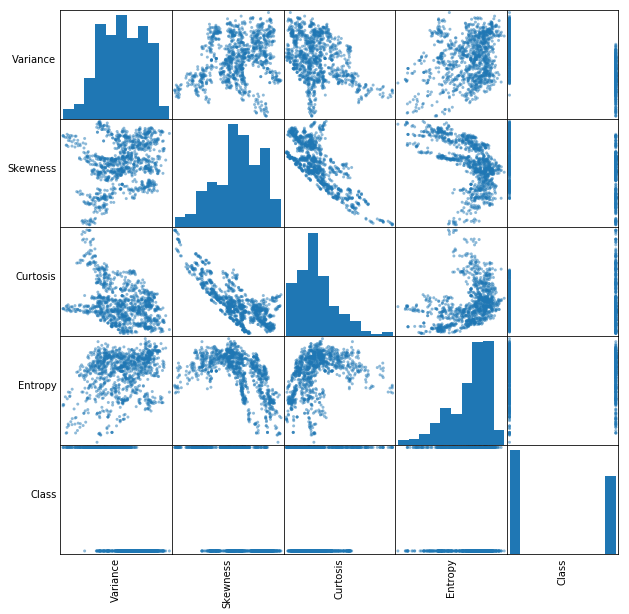

In [122]:
# Plot scatter matrix between the columns 
import pandas as pd
from pandas.plotting import scatter_matrix
numeric_features = [t[0] for t in df_spark.dtypes if t[1] == 'int' or t[1] == 'double']
sampled_data = df_spark.select(numeric_features).sample(False, 0.8).toPandas()
axs = scatter_matrix(sampled_data, figsize=(10, 10))
n = len(sampled_data.columns)
for i in range(n):
    v = axs[i, 0]
    v.yaxis.label.set_rotation(0)
    v.yaxis.label.set_ha('right')
    v.set_yticks(())
    h = axs[n-1, i]
    h.xaxis.label.set_rotation(90)
    h.set_xticks(())

In [123]:
# Correlation matrix between the input features and Class
import six
for i in df_spark.columns:
    if not( isinstance(df_spark.select(i).take(1)[0][0], six.string_types)):
        print( "Correlation to Class for ", i, df_spark.stat.corr('Class',i))

Correlation to Class for  Variance -0.7248431424446066
Correlation to Class for  Skewness -0.4446877575965928
Correlation to Class for  Curtosis 0.15588323600923024
Correlation to Class for  Entropy -0.023423678954851625
Correlation to Class for  Class 1.0


# Prepare Data for Machine Learning algorithm.Divide data into only two columns since spark support two columns only, one for features and the second one is label[Class]

In [124]:
# Spark support only two columns during training one for features and second one is labels
# Vector Assembler is used to assemble all the features used for training 
# Class in the label where to train a Classification model for estimating the 
# bill is counterfeit or not
from pyspark.ml.feature import VectorAssembler
vectorAssembler = VectorAssembler(inputCols = ['Variance', 'Skewness', 'Curtosis', 'Entropy'], outputCol = 'features')
Counterfeit_df = vectorAssembler.transform(df_spark)
Counterfeit_df= Counterfeit_df.select(['features', 'Class'])
Counterfeit_df.show(3)

+--------------------+-----+
|            features|Class|
+--------------------+-----+
|[3.6216,8.6661,-2...|    0|
|[4.5459,8.1674,-2...|    0|
|[3.866,-2.6383,1....|    0|
+--------------------+-----+
only showing top 3 rows



In [0]:
# Splitting data into training and testing 80% training and 20% testing
weights = [.8, .2]
#seed = 42 # seed=0L
rawTrainData, rawValidationData = Counterfeit_df.randomSplit(weights)

In [126]:
rawValidationData .show(100)

+--------------------+-----+
|            features|Class|
+--------------------+-----+
|[-6.7526,8.8172,-...|    1|
|[-6.7387,6.9879,0...|    1|
|[-6.5773,6.8017,0...|    1|
|[-6.3979,6.4479,1...|    1|
|[-6.3679,8.0102,0...|    1|
|[-6.2003,8.6806,0...|    1|
|[-6.0598,9.2952,-...|    1|
|[-5.9034,6.5679,0...|    1|
|[-5.4901,9.1048,-...|    1|
|[-5.3012,7.3915,0...|    1|
|[-5.2049,7.259,0....|    1|
|[-5.0477,-5.8023,...|    1|
|[-4.8861,7.0542,-...|    1|
|[-4.5046,-5.8126,...|    1|
|[-4.2091,4.7283,-...|    1|
|[-4.1958,-8.1819,...|    1|
|[-4.1429,2.7749,0...|    1|
|[-4.0214,-12.8006...|    1|
|[-3.9933,2.6218,0...|    1|
|[-3.9698,3.6812,-...|    1|
|[-3.9204,4.0723,-...|    1|
|[-3.8858,-12.8461...|    1|
|[-3.8203,-13.0551...|    1|
|[-3.8053,2.4273,0...|    1|
|[-3.7747,2.5162,0...|    1|
|[-3.7573,-8.2916,...|    1|
|[-3.5713,-12.4922...|    1|
|[-3.5637,-8.3827,...|    1|
|[-3.4917,-12.1736...|    1|
|[-3.4605,2.6901,0...|    1|
|[-3.3793,-13.7731...|    1|
|[-3.3582,-7.2

logistic Regression

In [127]:
# training the logistic regression madel
from pyspark.ml.classification import LogisticRegression
lr =  LogisticRegression(featuresCol = 'features', labelCol='Class', maxIter=10, regParam=0.3, elasticNetParam=0.8)
lr_model = lr.fit(rawTrainData)
print("Coefficients: " + str(lr_model.coefficients))
print("Intercept: " + str(lr_model.intercept))

Coefficients: [-0.14141091338891076,0.0,0.0,0.0]
Intercept: -0.1565653296574077


In [128]:
# Summary of the training data 
# Extract the summary from the returned LogisticRegressionModel instance trained
# in the earlier example
trainingSummary = lr_model.summary

# Obtain the objective per iteration
objectiveHistory = trainingSummary.objectiveHistory
print("objectiveHistory:")
for objective in objectiveHistory:
    print(objective)

# Obtain the receiver-operating characteristic as a dataframe and areaUnderROC.
trainingSummary.roc.show()
print("areaUnderROC: " + str(trainingSummary.areaUnderROC))

# Set the model threshold to maximize F-Measure
fMeasure = trainingSummary.fMeasureByThreshold
maxFMeasure = fMeasure.groupBy().max('F-Measure').select('max(F-Measure)').head()
bestThreshold = fMeasure.where(fMeasure['F-Measure'] == maxFMeasure['max(F-Measure)']) \
    .select('threshold').head()['threshold']
lr.setThreshold(bestThreshold)

objectiveHistory:
0.6876328208220864
0.6808795795141249
0.6643638950218351
0.6641809562801287
0.66417522610238
0.6641748419299395
0.6641748222999135
0.6641748215150979
0.6641748212322414
0.6641748211866081
0.6641748211797969
+--------------------+-------------------+
|                 FPR|                TPR|
+--------------------+-------------------+
|                 0.0|                0.0|
|                 0.0|0.02074688796680498|
|                 0.0|0.04149377593360996|
|                 0.0|0.06224066390041494|
|                 0.0|0.08298755186721991|
|0.001680672268907...| 0.1016597510373444|
|0.001680672268907...|0.12240663900414937|
|0.001680672268907...|0.14315352697095435|
|0.001680672268907...|0.16390041493775934|
|0.001680672268907...|0.18464730290456433|
|0.001680672268907...| 0.2053941908713693|
|0.001680672268907...|0.22614107883817428|
|0.001680672268907...|0.24688796680497926|
|0.001680672268907...| 0.2676348547717842|
|0.003361344537815...| 0.2863070539419087|
|

LogisticRegression_8a0195479576

In [129]:
rawTrainData.describe().show()

+-------+-------------------+
|summary|              Class|
+-------+-------------------+
|  count|               1077|
|   mean|0.44753946146703805|
| stddev| 0.4974712817670791|
|    min|                  0|
|    max|                  1|
+-------+-------------------+



In [130]:
# Testing the trained logistic regression model
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
lr_predictions = lr_model.transform(rawValidationData)
lr_predictions.select("prediction","Class","features").show(5)
# Select (prediction, true label) and compute test error
evaluator = MulticlassClassificationEvaluator(
    labelCol="Class", predictionCol="prediction", metricName="accuracy")
accuracy = evaluator.evaluate(lr_predictions)
print("Test Error = %g " % (1.0 - accuracy))
print("Accuracy = %g " % ( accuracy))


+----------+-----+--------------------+
|prediction|Class|            features|
+----------+-----+--------------------+
|       1.0|    1|[-6.7526,8.8172,-...|
|       1.0|    1|[-6.7387,6.9879,0...|
|       1.0|    1|[-6.5773,6.8017,0...|
|       1.0|    1|[-6.3979,6.4479,1...|
|       1.0|    1|[-6.3679,8.0102,0...|
+----------+-----+--------------------+
only showing top 5 rows

Test Error = 0.183051 
Accuracy = 0.816949 


In [131]:
areaUnderROC_Test = BinaryClassificationEvaluator(metricName = 'areaUnderROC', labelCol="Class")
ART = areaUnderROC_Test.evaluate(lr_predictions)
print("Area Under Curve test",ART)

Area Under Curve test 0.9316991017964074


Decision Tree Classification

In [132]:
# Training and testing the decision tree model 
from pyspark.ml.classification import DecisionTreeClassifier
dt = DecisionTreeClassifier(featuresCol = 'features', labelCol='Class')
dt_model = dt.fit(rawTrainData)
dt_predictions = dt_model.transform(rawValidationData)
evaluator = MulticlassClassificationEvaluator(
    labelCol="Class", predictionCol="prediction", metricName="accuracy")
accuracy = evaluator.evaluate(dt_predictions)
print("Test Error = %g " % (1.0 - accuracy))
print("Accuracy = %g " % ( accuracy))

Test Error = 0.0271186 
Accuracy = 0.972881 


In [133]:
areaUnderROC_Test = BinaryClassificationEvaluator(metricName = 'areaUnderROC', labelCol="Class")
ART = areaUnderROC_Test.evaluate(dt_predictions)
print("Area Under Curve test",ART)

Area Under Curve test 0.9910179640718563


Gradient Boosting tree Classification

In [135]:
# Training and testing the Gradient Boosting model
from pyspark.ml.classification import GBTClassifier
gbt = GBTClassifier(featuresCol = 'features', labelCol='Class')
gbt_model = gbt.fit(rawTrainData)
gbt_predictions = gbt_model.transform(rawValidationData)
gbt_predictions.select('prediction', 'Class', 'features').show(5)
evaluator = MulticlassClassificationEvaluator(
    labelCol="Class", predictionCol="prediction", metricName="accuracy")
accuracy = evaluator.evaluate(gbt_predictions)
print("Test Error = %g " % (1.0 - accuracy))
print("Accuracy = %g " % ( accuracy))

+----------+-----+--------------------+
|prediction|Class|            features|
+----------+-----+--------------------+
|       1.0|    1|[-6.7526,8.8172,-...|
|       1.0|    1|[-6.7387,6.9879,0...|
|       1.0|    1|[-6.5773,6.8017,0...|
|       1.0|    1|[-6.3979,6.4479,1...|
|       1.0|    1|[-6.3679,8.0102,0...|
+----------+-----+--------------------+
only showing top 5 rows

Test Error = 0.0101695 
Accuracy = 0.989831 


In [136]:
# Area under Curve 
areaUnderROC_Test = BinaryClassificationEvaluator(metricName = 'areaUnderROC', labelCol="Class")
ART = areaUnderROC_Test.evaluate(gbt_predictions)
print("Area Under Curve test",ART)

Area Under Curve test 0.999438622754491


**Random Forest **

In [137]:
# Training and testing the Random Forest model
from pyspark.ml.classification import RandomForestClassifier
rf = RandomForestClassifier(featuresCol = 'features', labelCol='Class')
rf_model = rf.fit(rawTrainData)
rf_predictions = rf_model.transform(rawValidationData)
rf_predictions.select('prediction', 'Class', 'features').show(5)
valuator = MulticlassClassificationEvaluator(
    labelCol="Class", predictionCol="prediction", metricName="accuracy")
accuracy = evaluator.evaluate(rf_predictions)
print("Test Error = %g " % (1.0 - accuracy))
print("Accuracy = %g " % ( accuracy))

+----------+-----+--------------------+
|prediction|Class|            features|
+----------+-----+--------------------+
|       1.0|    1|[-6.7526,8.8172,-...|
|       1.0|    1|[-6.7387,6.9879,0...|
|       1.0|    1|[-6.5773,6.8017,0...|
|       1.0|    1|[-6.3979,6.4479,1...|
|       1.0|    1|[-6.3679,8.0102,0...|
+----------+-----+--------------------+
only showing top 5 rows

Test Error = 0.0169492 
Accuracy = 0.983051 


In [138]:
# Area under Curve 
areaUnderROC_Test = BinaryClassificationEvaluator(metricName = 'areaUnderROC', labelCol="Class")
ART = areaUnderROC_Test.evaluate(rf_predictions)
print("Area Under Curve test",ART)

Area Under Curve test 0.9993450598802395


SVM model for Classification

In [140]:
# Training and testing the SVM model
from pyspark.ml.classification import  LinearSVC
lsvc = LinearSVC(maxIter=10, regParam=0.1,featuresCol = 'features', labelCol='Class')
lsvc_model = lsvc.fit(rawTrainData)
lsvm_predictions = lsvc_model.transform(rawValidationData)
lsvm_predictions.select('prediction', 'Class', 'features').show(5)
valuator = MulticlassClassificationEvaluator(
    labelCol="Class", predictionCol="prediction", metricName="accuracy")
accuracy = evaluator.evaluate(lsvm_predictions)
print("Test Error = %g " % (1.0 - accuracy))
print("Accuracy = %g " % ( accuracy))

+----------+-----+--------------------+
|prediction|Class|            features|
+----------+-----+--------------------+
|       1.0|    1|[-6.7526,8.8172,-...|
|       1.0|    1|[-6.7387,6.9879,0...|
|       1.0|    1|[-6.5773,6.8017,0...|
|       1.0|    1|[-6.3979,6.4479,1...|
|       1.0|    1|[-6.3679,8.0102,0...|
+----------+-----+--------------------+
only showing top 5 rows

Test Error = 0.0135593 
Accuracy = 0.986441 


In [141]:
# Area under Curve 
areaUnderROC_Test = BinaryClassificationEvaluator(metricName = 'areaUnderROC', labelCol="Class")
ART = areaUnderROC_Test.evaluate(lsvm_predictions)
print("Area Under Curve test",ART)

Area Under Curve test 0.9994854041916168


MLP Classifier 

In [144]:
from pyspark.ml.classification import MultilayerPerceptronClassifier
# input layer of size 4 (features), two intermediate of size 5 and 4
# and output of size 2 (classes  = 1 or 0)
layers = [4, 5, 4, 2]
# create the trainer and set its parameters
trainer = MultilayerPerceptronClassifier(maxIter=100, layers=layers, blockSize=128, seed=1234,featuresCol = 'features', labelCol='Class')
# train the model
model = trainer.fit(rawTrainData)
MLP_predictions = model.transform(rawValidationData)
MLP_predictions.select('prediction', 'Class', 'features').show(5)
valuator = MulticlassClassificationEvaluator(
    labelCol="Class", predictionCol="prediction", metricName="accuracy")
accuracy = evaluator.evaluate(MLP_predictions)
print("Test Error = %g " % (1.0 - accuracy))
print("Accuracy = %g " % ( accuracy))


+----------+-----+--------------------+
|prediction|Class|            features|
+----------+-----+--------------------+
|       1.0|    1|[-6.7526,8.8172,-...|
|       1.0|    1|[-6.7387,6.9879,0...|
|       1.0|    1|[-6.5773,6.8017,0...|
|       1.0|    1|[-6.3979,6.4479,1...|
|       1.0|    1|[-6.3679,8.0102,0...|
+----------+-----+--------------------+
only showing top 5 rows

Test Error = 0 
Accuracy = 1 


In [145]:
# Area under Curve 
areaUnderROC_Test = BinaryClassificationEvaluator(metricName = 'areaUnderROC', labelCol="Class")
ART = areaUnderROC_Test.evaluate(MLP_predictions)
print("Area Under Curve test",ART)


Area Under Curve test 1.0
